In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
import zipfile
warnings.filterwarnings('ignore')

In [4]:
zipped_snake_folder=r'/content/drive/MyDrive/snake_cleaned_2_updated.zip'
unzipped_path='/content/'
with zipfile.ZipFile(zipped_snake_folder,'r') as zip_ref:
  zip_ref.extractall(unzipped_path)

In [6]:
file_path=r'/content/Snake_cleaned_2/Snake_cleaned_dataset'
snake_count={}
for i,name in enumerate(os.listdir(file_path)):
  curr_path=os.path.join(file_path,name)
  snake_count[name]=len(os.listdir(curr_path))


In [7]:
snake_count

{'Indian Rock Python': 359,
 'Russel viper': 428,
 'common sandboa': 243,
 'Checkered Keelback': 320,
 'rat snake': 219,
 'Green Tree Vine': 295,
 'banded racer': 290,
 'Spectacled Cobra': 406,
 'King Cobra': 314,
 'saw scaled': 406,
 'common krait': 347,
 'common trinket': 302}

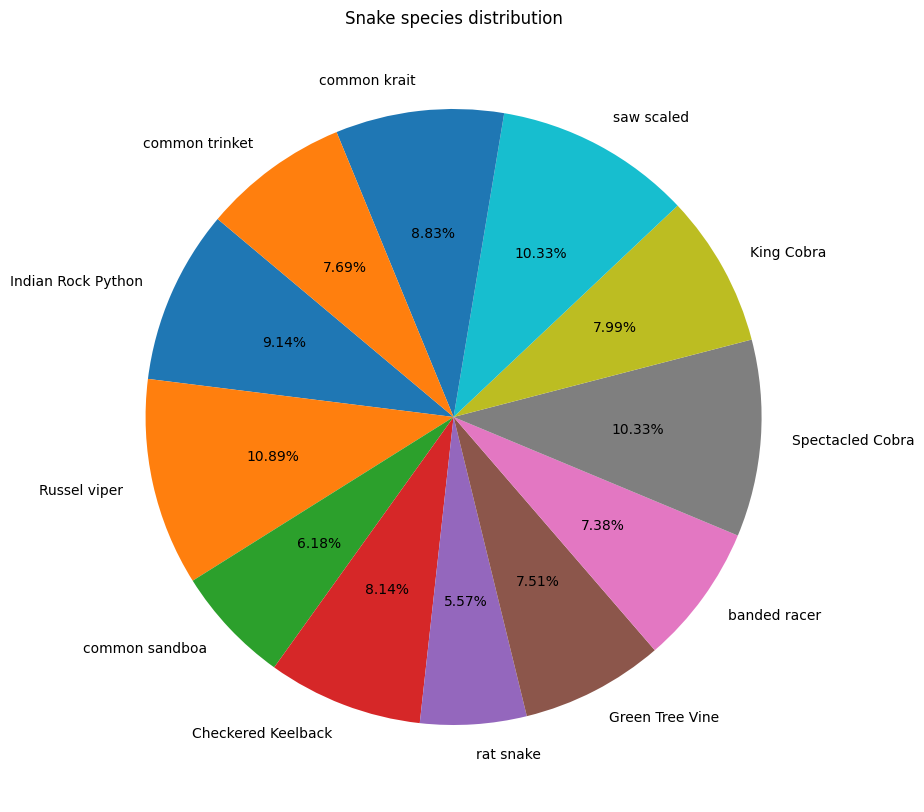

In [8]:
plt.figure(figsize=(10,10))
plt.pie(snake_count.values(),labels=snake_count.keys(),autopct='%1.2f%%',
    startangle=140)
plt.title('Snake species distribution')
plt.show()

In [9]:
!pip install split-folders


In [10]:
import splitfolders
input_folder=file_path
output_folder='/content/snakeData-split'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2))

Copying files: 3929 files [00:02, 1429.11 files/s]


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_imageAugumenation=ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5,1.6],
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
  )

In [12]:
train_datagen=train_imageAugumenation.flow_from_directory(
   '/content/snakeData-split/train',
    subset='training',
    batch_size=64,
    target_size=(356,356),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

Found 3031 images belonging to 12 classes.


In [13]:

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/snakeData-split/val',
    target_size=(356,356),
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 764 images belonging to 12 classes.


In [14]:
snake_names=list(train_datagen.class_indices.keys())
snake_names

['Checkered Keelback',
 'Green Tree Vine',
 'Indian Rock Python',
 'King Cobra',
 'Russel viper',
 'Spectacled Cobra',
 'banded racer',
 'common krait',
 'common sandboa',
 'common trinket',
 'rat snake',
 'saw scaled']

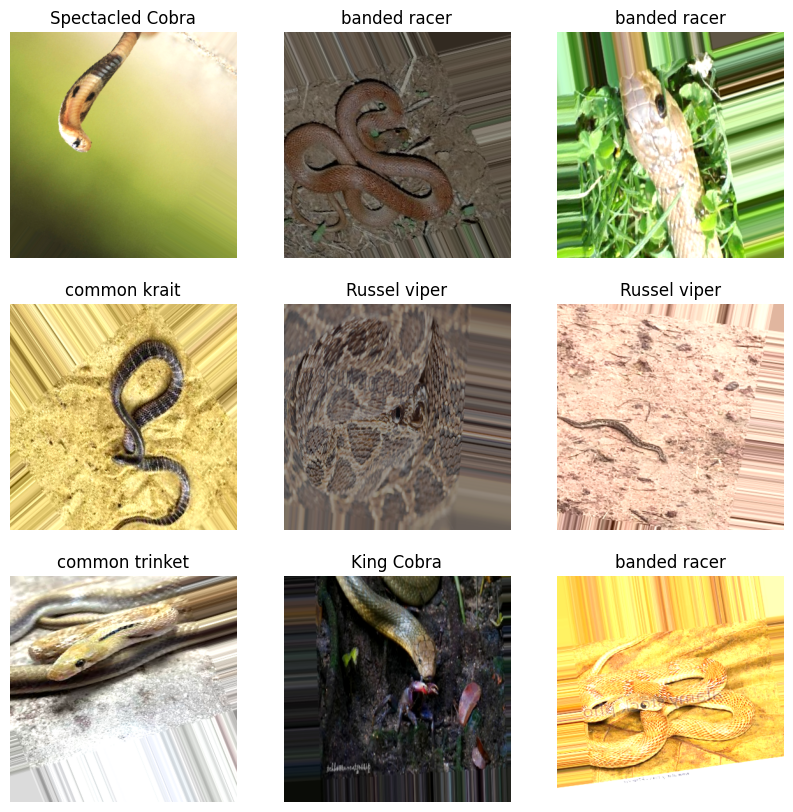

In [15]:
plt.figure(figsize=(10,10))
for x,y in train_datagen:
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x[i])
    plt.title(snake_names[np.argmax(y[i])])
    plt.axis('off')
  break
  plt.tight_layout()
  plt.show()


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
base_model = MobileNetV2(input_shape=(356,356, 3), include_top=False, weights='imagenet')
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(12, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
early=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)
reduce=ReduceLROnPlateau(monitor='val_accuracy',patience=5,factor=0.5)
checkpoint=ModelCheckpoint('best_model.keras',monitor='val_accuracy',save_best_only=True)
callbacks=[early,reduce,checkpoint]

In [18]:

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
history = model.fit(
    train_datagen,
    validation_data=test_generator,
    epochs=20,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.2296 - loss: 2.7377 - val_accuracy: 0.5746 - val_loss: 1.4640 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.4943 - loss: 1.5998 - val_accuracy: 0.6453 - val_loss: 1.1821 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5448 - loss: 1.3831 - val_accuracy: 0.7199 - val_loss: 0.9871 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.6102 - loss: 1.1881 - val_accuracy: 0.6806 - val_loss: 0.9886 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.6140 - loss: 1.2077 - val_accuracy: 0.7173 - val_loss: 0.8617 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.6385 - loss: 1.0650 - val_accuracy: 0.7264 - val_loss: 0.8324 - learning_rate: 0.0010
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.6514 - loss: 1.0793 - val_acc

In [20]:
loss, acc = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 723ms/step - accuracy: 0.7875 - loss: 0.6999
Test Loss: 0.6881663799285889
Test Accuracy: 0.7931936979293823


12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


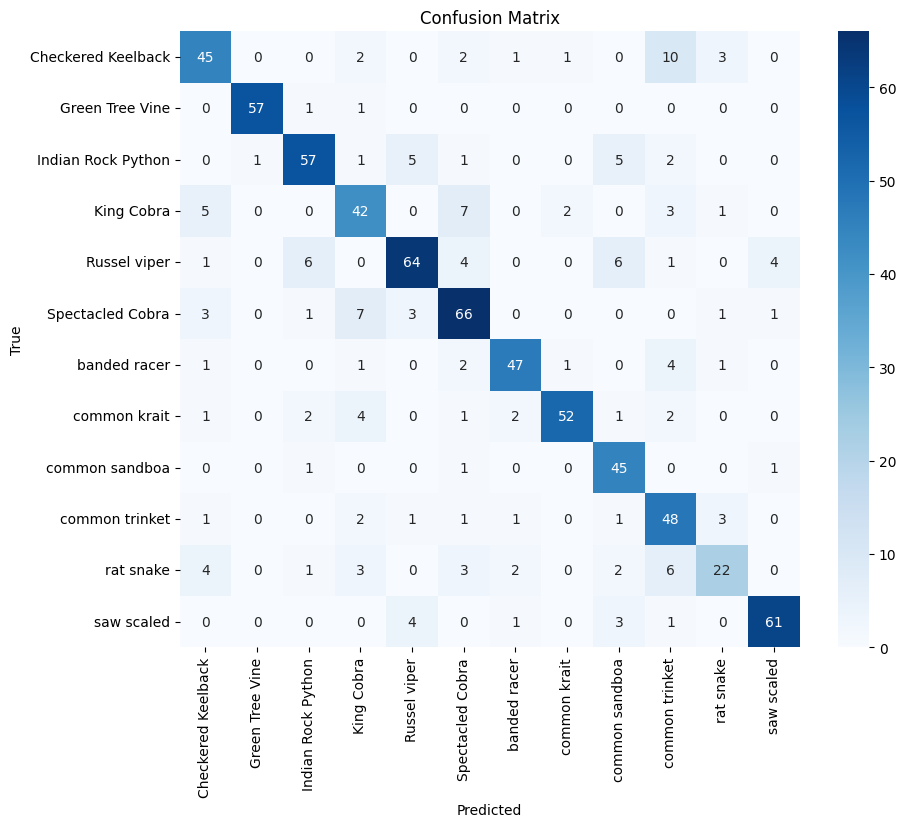

[[45  0  0  2  0  2  1  1  0 10  3  0]
 [ 0 57  1  1  0  0  0  0  0  0  0  0]
 [ 0  1 57  1  5  1  0  0  5  2  0  0]
 [ 5  0  0 42  0  7  0  2  0  3  1  0]
 [ 1  0  6  0 64  4  0  0  6  1  0  4]
 [ 3  0  1  7  3 66  0  0  0  0  1  1]
 [ 1  0  0  1  0  2 47  1  0  4  1  0]
 [ 1  0  2  4  0  1  2 52  1  2  0  0]
 [ 0  0  1  0  0  1  0  0 45  0  0  1]
 [ 1  0  0  2  1  1  1  0  1 48  3  0]
 [ 4  0  1  3  0  3  2  0  2  6 22  0]
 [ 0  0  0  0  4  0  1  0  3  1  0 61]]


In [21]:
from sklearn.metrics import confusion_matrix

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Confusion matrix
cf = confusion_matrix(y_true, y_pred_classes)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print(cf)



In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_classes,y_true))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72        61
           1       0.97      0.98      0.97        58
           2       0.79      0.83      0.81        69
           3       0.70      0.67      0.68        63
           4       0.74      0.83      0.79        77
           5       0.80      0.75      0.78        88
           6       0.82      0.87      0.85        54
           7       0.80      0.93      0.86        56
           8       0.94      0.71      0.81        63
           9       0.83      0.62      0.71        77
          10       0.51      0.71      0.59        31
          11       0.87      0.91      0.89        67

    accuracy                           0.79       764
   macro avg       0.79      0.80      0.79       764
weighted avg       0.80      0.79      0.79       764



In [23]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(accuracy))


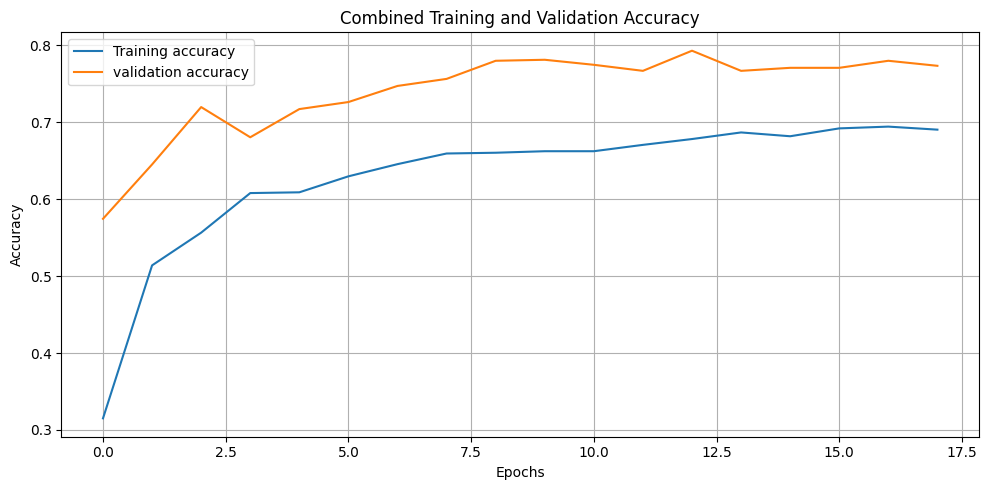

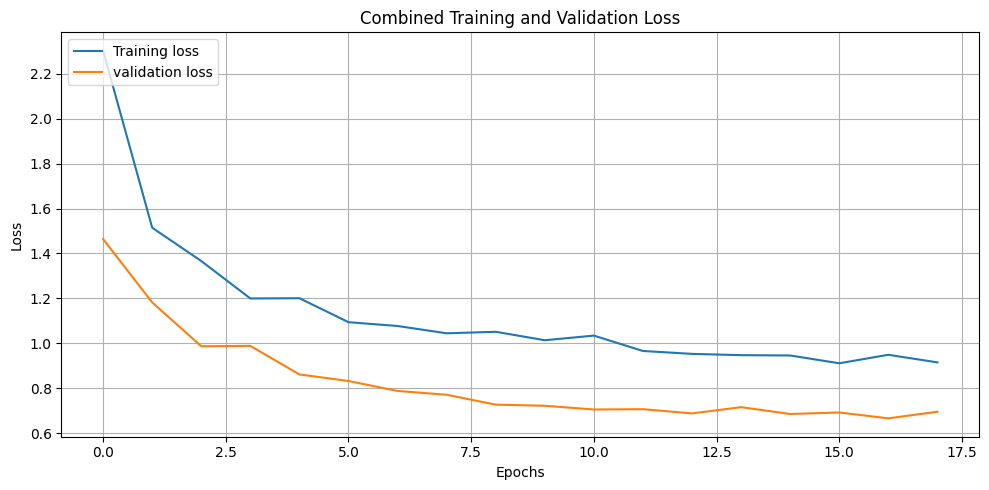

In [24]:
plt.figure(figsize=(10,5))
plt.plot(epochs,accuracy,label='Training accuracy')
plt.plot(epochs,val_accuracy,label='validation accuracy')
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Combined Training and Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,label='Training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('Combined Training and Validation Loss')
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()